### ALS Movie Example Databricks Notebook
##### by Daniel Ciborowski, dciborow@microsoft.com

##### Copyright (c) Microsoft Corporation. All rights reserved.

##### Licensed under the MIT License.

##### Setup
1. Create new Cluster, DB 4.1, Spark 2.3.0, Python3
1. Add Azure-cli via pypi - azure-cli
1. Add AzureML via Pypi - azureml-sdk[databricks]
1. Add pydocumentdb via Pypi
1. Add CosmosDB uber jar via maven central - https://search.maven.org/artifact/com.microsoft.azure/azure-cosmosdb-spark_2.3.0_2.11/1.2.2

[See here for help adding a library.](https://docs.databricks.com/user-guide/libraries.html)

##### This notebook is broken down into four sections.
1. Service Creation
1. Training
1. Scoring
1. Operationalization

##### The following Azure services will be deployed into a new or existing resource group.
1. [ML Service](https://docs.databricks.com/user-guide/libraries.html)
1. [Cosmos DB](https://azure.microsoft.com/en-us/services/cosmos-db/)
1. [Container Registery](https://docs.microsoft.com/en-us/azure/container-registry/)
1. [Container Instances](https://docs.microsoft.com/en-us/azure/container-instances/)
1. [Application Insights](https://azure.microsoft.com/en-us/services/monitor/)
1. Storage Account
1. Key Vault

# I. Service Creation

In [3]:
from azure.common.client_factory import get_client_from_cli_profile
from azure.mgmt.compute import ComputeManagementClient
import azure.mgmt.cosmosdb

import azureml.core
from azureml.core import Workspace
from azureml.core.run import Run
from azureml.core.experiment import Experiment

import pydocumentdb
import pydocumentdb.document_client as document_client

from pyspark.ml import Pipeline, PipelineModel
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.feature import StringIndexer
from pyspark.ml.recommendation import ALS
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.sql import Row

import numpy as np
import os
import pandas as pd
import pprint
import shutil
import time, timeit
import urllib
import yaml

# Check core SDK version number - based on build number of preview/master.
print("SDK version:", azureml.core.VERSION)

SDK version: 0.1.59

In [4]:
prefix = dbutils.widgets.get("Prefix")
data = dbutils.widgets.get("Dataset")
algo = dbutils.widgets.get("Algo")

resource_group = prefix + "_" + data
workspace_name = prefix + "_"+data+"_aml"
workspace_region = "westus2"

#Columns
userCol=dbutils.widgets.get("Column User")
itemCol=dbutils.widgets.get("Column Item")
ratingCol=dbutils.widgets.get("Column Rating")

userColIndex = userCol.replace("Id","Index")
itemColIndex = itemCol.replace("Id","Index")

#CosmosDB
location = 'westus2'
account_name = prefix + "-" + data + "-ds-sql"
DOCUMENTDB_DATABASE = "recommendations"
DOCUMENTDB_COLLECTION = "user_recommendations_" + algo

#AzureML
history_name = 'spark-ml-notebook'
model_name = data+"-"+algo+"-Recommendations.mml"
service_name = data + "-" + algo
experiment_name = data + "_"+ algo +"_Experiment"

train_data_path = data + "Train"
test_data_path = data + "Test"

subscription_id = dbutils.widgets.get("Subscription")

In [5]:
# import the Workspace class and check the azureml SDK version
# exist_ok checks if workspace exists or not.
ws = Workspace.create(name = workspace_name,
                      subscription_id = subscription_id,
                      resource_group = resource_group, 
                      location = workspace_region,
                      exist_ok=True)

# persist the subscription id, resource group name, and workspace name in aml_config/config.json.
ws.write_config()

Wrote the config file config.json to: /databricks/driver/aml_config/config.json

In [6]:
def find_collection(client, dbid, id):
        database_link = 'dbs/' + dbid
        collections = list(client.QueryCollections(
            database_link,
            {
                "query": "SELECT * FROM r WHERE r.id=@id",
                "parameters": [
                    { "name":"@id", "value": id }
                ]
            }
        ))

        if len(collections) > 0:
            return True
        else:
            return False
def read_collection(client, dbid, id):
        try:
            database_link = 'dbs/' + dbid
            collection_link = database_link + '/colls/{0}'.format(id)

            collection = client.ReadCollection(collection_link)
            return collection
        except errors.DocumentDBError as e:
            if e.status_code == 404:
               print('A collection with id \'{0}\' does not exist'.format(id))
            else: 
                raise errors.HTTPFailure(e.status_code)    

def read_database(client, id):
    try:
        database_link = 'dbs/' + id

        database = client.ReadDatabase(database_link)
        return database
    except errors.DocumentDBError as e:
        if e.status_code == 404:
           print('A database with id \'{0}\' does not exist'.format(id))
        else: 
            raise errors.HTTPFailure(e.status_code)  
            
def find_database(client, id):
        databases = list(client.QueryDatabases({
            "query": "SELECT * FROM r WHERE r.id=@id",
            "parameters": [
                { "name":"@id", "value": id }
            ]
        }))

        if len(databases) > 0:
            return True
        else:
            return False            

client = get_client_from_cli_profile(azure.mgmt.cosmosdb.CosmosDB)

async_cosmosdb_create = client.database_accounts.create_or_update(
    resource_group,
    account_name,
    {
        'location': location,
        'locations': [{
            'location_name': location
        }]
    }
)
account = async_cosmosdb_create.result()

my_keys = client.database_accounts.list_keys(
    resource_group,
    account_name
)
master_key = my_keys.primary_master_key
endpoint = "https://" + account_name + ".documents.azure.com:443/"
#db client
client = document_client.DocumentClient(endpoint, {'masterKey': master_key})

if find_database(client, DOCUMENTDB_DATABASE) == False:
  db = client.CreateDatabase({ 'id': DOCUMENTDB_DATABASE })
else:
  db = read_database(client, DOCUMENTDB_DATABASE)
# Create collection options
options = {
    'offerThroughput': 11000
}

# Create a collection
collection_definition = { 'id': DOCUMENTDB_COLLECTION, 'partitionKey': {'paths': ['/id'],'kind': 'Hash'} }
if find_collection(client,DOCUMENTDB_DATABASE,  DOCUMENTDB_COLLECTION) ==False:
  collection = client.CreateCollection(db['_self'], collection_definition, options)
else:
  collection = read_collection(client, DOCUMENTDB_DATABASE, DOCUMENTDB_COLLECTION)
secrets = {
  "Endpoint": endpoint,
  "Masterkey": master_key,
  "Database": DOCUMENTDB_DATABASE,
  "Collection": DOCUMENTDB_COLLECTION,
  "Upsert": "true"
}
import json
with open("secrets.json", "w") as file:
    json.dump(secrets, file)

# II. Training

In [8]:
# Download Movie Lens
basedataurl = "http://aka.ms" 
datafile = "MovieRatings.csv"

datafile_dbfs = os.path.join("/dbfs", datafile)

if os.path.isfile(datafile_dbfs):
    print("found {} at {}".format(datafile, datafile_dbfs))
else:
    print("downloading {} to {}".format(datafile, datafile_dbfs))
    urllib.request.urlretrieve(os.path.join(basedataurl, datafile), datafile_dbfs)
    
data_all = sqlContext.read.format('csv')\
                     .options(header='true', delimiter=',', inferSchema='true', ignoreLeadingWhiteSpace='true', ignoreTrailingWhiteSpace='true')\
                     .load(datafile)    
data_all.printSchema()
display(data_all)

UserId,MovieId,Rating,Timestamp
1,68646,10,1381620027
1,113277,10,1379466669
2,454876,8,1394818630
2,790636,7,1389963947
2,816711,8,1379963769
2,1091191,7,1391173869
2,1322269,7,1391529691
2,1433811,8,1380453043
2,1454468,8,1387016442
2,1535109,8,1386350135


In [9]:
train, test = data_all.cache().randomSplit([0.75, 0.25], seed=123)

print("train ({}, {})".format(train.cache().count(), len(train.columns)))
print("test ({}, {})".format(test.cache().count(), len(test.columns)))

train_data_path_dbfs = os.path.join("/dbfs", train_data_path)
test_data_path_dbfs = os.path.join("/dbfs", test_data_path)

train.write.mode('overwrite').parquet(train_data_path)
test.write.mode('overwrite').parquet(test_data_path)
print("train and test datasets saved to {} and {}".format(train_data_path_dbfs, test_data_path_dbfs))

train (170746, 4)
test (56726, 4)
train and test datasets saved to /dbfs/moviesTrain and /dbfs/moviesTest

In [10]:
#from tqdm import tqdm
model_dbfs = os.path.join("/dbfs", model_name)

# start a training run by defining an experiment
myexperiment = Experiment(ws, experiment_name)
root_run = myexperiment.start_logging()

In [11]:
indexerContacts = StringIndexer(inputCol=userCol, outputCol=userColIndex, handleInvalid='keep').fit(data_all)
indexerRules = StringIndexer(inputCol=itemCol, outputCol=itemColIndex, handleInvalid='keep').fit(data_all)

als = ALS(maxIter=5, userCol=userColIndex, itemCol=itemColIndex, ratingCol=ratingCol, coldStartStrategy="drop")

# put together the pipeline
pipe = Pipeline(stages=[indexerContacts, indexerRules, als])

In [12]:
# Regularization Rates
regs = [1, 0.1, 0.01, 0.001]
paramGrid = ParamGridBuilder().addGrid(als.regParam, regs).build()

evaluator = RegressionEvaluator(metricName="rmse", labelCol=ratingCol, predictionCol="prediction")
cv = CrossValidator(estimator=pipe, evaluator=evaluator, estimatorParamMaps=paramGrid)
train.cache()
cvModel = cv.fit(train)
i = 0

In [13]:
# record a bunch of reg values in a ALS model
for reg in regs:
    print(reg)
    # create a bunch of child runs
    with root_run.child_run("reg-" + str(reg)) as run:
        rmse = cvModel.avgMetrics[i]
        print("Root-mean-square error = " + str(rmse))
        
        # log reg, rmse and feature names in run history
        run.log("reg", reg)
        run.log("rmse", rmse)
        run.log_list("columns", train.columns)
        i += 1

1
Root-mean-square error = 1.916122854573241
0.1
Root-mean-square error = 2.590635169307214
0.01
Root-mean-square error = 7.209615787157562
0.001
Root-mean-square error = 17.035763046960327

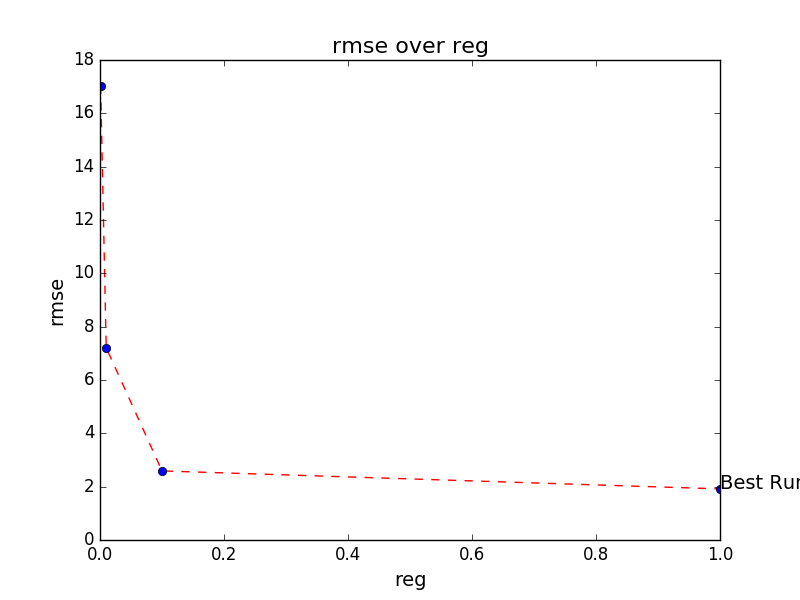

In [14]:
#%matplotlib inline
#Load all run metrics from run history into a dictionary object.
child_runs = {}
child_run_metrics = {}

for r in root_run.get_children():
    child_runs[r.id] = r
    child_run_metrics[r.id] = r.get_metrics()

#Now find the run with the lowest rmse
best_run_id = min(child_run_metrics, key = lambda k: child_run_metrics[k]['rmse'])
best_run = child_runs[best_run_id]
print('Best run is:', best_run_id)
print('Metrics:', child_run_metrics[best_run_id])    
    
import matplotlib
import matplotlib.pyplot as plt
fig, ax = plt.subplots()

best_reg = child_run_metrics[best_run_id]['reg']
max_auc = child_run_metrics[best_run_id]['rmse']

reg_auc = np.array([(child_run_metrics[k]['reg'], child_run_metrics[k]['rmse']) for k in child_run_metrics.keys()])
reg_auc_sorted = reg_auc[reg_auc[:,0].argsort()]

ax.plot(reg_auc_sorted[:,0], reg_auc_sorted[:,1], 'r--')
ax.plot(reg_auc_sorted[:,0], reg_auc_sorted[:,1], 'bo')

ax.set_xlabel('reg', fontsize = 14)
ax.set_ylabel('rmse', fontsize = 14)
ax.set_title('rmse over reg', fontsize = 16)

# plot arrow
ax.arrow(x = best_reg + 0.45, y = max_auc, dx = -0.4, dy = 0, ls = '-', lw = 0.00001,
          width = 0.00001, head_width = 0.00002, head_length = 0.02)

# plot "best run" text
ax.text(x = best_reg, y = max_auc, s = 'Best Run', fontsize = 14)
#plt.show()

display(fig)

In [15]:
# save model
cvModel.bestModel.write().overwrite().save(model_name)
print("Model saved")

# upload the serialized model into run history record
mdl, ext = model_name.split(".")
model_zip = mdl + ".zip"
shutil.make_archive(mdl, 'zip', model_dbfs)
root_run.upload_file("outputs/" + model_name, model_zip)        

# now delete the serialized model from local folder since it is already uploaded to run history 
# shutil.rmtree(model_dbfs)
os.remove(model_zip)
        
# Declare run completed
root_run.complete()

##NOTE: service deployment always gets the model from the current working dir.
print("copy model from dbfs to local")
model_local = "file:" + os.getcwd() + "/" + model_name
dbutils.fs.cp(model_name, model_local, True)

Model saved
copy model from dbfs to local
 Out[ 68 ]: True

In [16]:
pred = cvModel.transform(test)
display(pred)

re = RegressionEvaluator(metricName="rmse", labelCol=ratingCol,
                                predictionCol="prediction")
rmse = re.evaluate(pred)
print("Root-mean-square error = " + str(rmse))

UserId,MovieId,Rating,Timestamp,UserIndex,MovieIndex,prediction
13482,1959490,1,1396645733,137.0,148.0,5.66305
818,1959490,8,1395985808,7530.0,148.0,6.042117
7628,1959490,1,1396139446,458.0,148.0,5.859103
20232,1959490,1,1396641049,10090.0,148.0,5.806978
373,1959490,9,1396784024,4097.0,148.0,6.9198594
13488,1959490,10,1396796498,4512.0,148.0,6.0549827
17686,1959490,10,1396060596,1869.0,148.0,5.7855725
25502,1959490,5,1396818976,914.0,148.0,5.1027184
5962,1959490,6,1397064712,27.0,148.0,5.7274933
17588,1959490,6,1396801207,2031.0,148.0,4.9753556


# III. Scoring

In [18]:
import json
with open('secrets.json') as json_data:
  writeConfig = json.load(json_data)

  recs = cvModel.bestModel.stages[2].recommendForAllUsers(10)
  recs.withColumn("id",recs[userColIndex].cast("string")).select("id", "recommendations."+ itemColIndex)\
    .write.format("com.microsoft.azure.cosmosdb.spark").mode('overwrite').options(**writeConfig).save()

# IV. Operationalization

In [20]:
#%%writefile score_sparkml.py

score_sparkml = """

import json
def init(local=False):
    global client, collection
    try:
      # Query them in SQL
      import pydocumentdb.document_client as document_client

      MASTER_KEY = '{key}'
      HOST = '{endpoint}'
      DATABASE_ID = "{database}"
      COLLECTION_ID = "{collection}"
      database_link = 'dbs/' + DATABASE_ID
      collection_link = database_link + '/colls/' + COLLECTION_ID
      
      client = document_client.DocumentClient(HOST, {'masterKey': MASTER_KEY})
      collection = client.ReadCollection(collection_link=collection_link)
    except Exception as e:
      collection = e
def run(input_json):      

    try:
      import json

      id = json.loads(json.loads(input_json)[0])['id']
      query = {'query': 'SELECT * FROM c WHERE c.id = "' + str(id) +'"' } #+ str(id)

      options = {}

      result_iterable = client.QueryDocuments(collection['_self'], query, options)
      result = list(result_iterable);
  
    except Exception as e:
        result = str(e)
    return json.dumps(str(result)) #json.dumps({{"result":result}})
"""

import json
with open('secrets.json') as json_data:
  writeConfig = json.load(json_data)
  score_sparkml = score_sparkml.replace("{key}",writeConfig['Masterkey']).replace("{endpoint}",writeConfig['Endpoint']).replace("{database}",writeConfig['Database']).replace("{collection}",writeConfig['Collection'])

  exec(score_sparkml)

  with open("score_sparkml.py", "w") as file:
      file.write(score_sparkml)

In [21]:
%%writefile myenv_sparkml.yml

name: myenv
channels:
  - defaults
dependencies:
  - pip:
    - numpy==1.14.2
    - scikit-learn==0.19.1
    - pandas
    # Required packages for AzureML execution, history, and data preparation.
    - --extra-index-url https://azuremlsdktestpypi.azureedge.net/sdk-release/Preview/E7501C02541B433786111FE8E140CAA1
    - azureml-core
    - pydocumentdb

Overwriting myenv_sparkml.yml

In [22]:
from azureml.core.webservice import AciWebservice, Webservice
#aci = azure container instance
aci_config = AciWebservice.deploy_configuration(
    cpu_cores = 1, 
    memory_gb = 1, 
    tags = {'name':'Spark ML Databricks sample'}, 
    description = 'This is a great example.')

In [23]:
from azureml.core.model import Model
mymodel = Model.register(model_path = model_name, # this points to a local file
                       model_name = model_name, # this is the name the model is registered as, am using same name for both path and name.                 
                       description = "ADB trained model by Dan",
                       workspace = ws)

print(mymodel.name, mymodel.description, mymodel.version)

Registering model movies-als-Recommendations.mml
movies-als-Recommendations.mml ADB trained model by Dan 2

In [24]:
models = [mymodel]
runtime = "spark-py"
conda_file = 'myenv_sparkml.yml'
driver_file = "score_sparkml.py"

# image creation
from azureml.core.image import ContainerImage
myimage_config = ContainerImage.image_configuration(execution_script = driver_file, 
                                    runtime = runtime, 
                                    conda_file = conda_file)


In [25]:
try:
  myservice = AciWebservice(ws, name=service_name)
except:
  myservice = Webservice.deploy_from_model(
    workspace=ws, 
    name=service_name,
    deployment_config = aci_config,
    models = models,
    image_config = myimage_config
      )

  myservice.wait_for_deployment(show_output=True)

print(yaml.dump(myservice.__dict__, default_flow_style=False))

_auth: &id001 !!python/object:azureml.core.authentication.InteractiveLoginAuthentication
 _auth: !!python/object:azureml.core.authentication.AzureCliAuthentication {}
_mms_endpoint: https://westus2.modelmanagement.azureml.net/api/subscriptions/03909a66-bef8-4d52-8e9a-a346604e0902/resourceGroups/dcib_movies/providers/Microsoft.MachineLearningServices/workspaces/dcib_movies_aml/services/movies-als
_operation_endpoint: null
app_insights_enabled: false
auth_enabled: false
cname: null
compute_type: ACI
container_resource_requirements: !!python/object:azureml.core.webservice.aci.ContainerResourceRequirements
 cpu: 1.0
 memory_in_gb: 1.0
created_time: 2018-09-22 03:14:42.892262+00:00
description: This is a great example.
error: null
image: !!python/object:azureml.core.image.container.ContainerImage
 _auth: *id001
 _mms_endpoint: https://westus2.modelmanagement.azureml.net/api/subscriptions/03909a66-bef8-4d52-8e9a-a346604e0902/resourceGroups/dcib_movies/providers/Microsoft.MachineLearningServices/workspaces/dcib_movies_aml/images/movies-als:1
 _operation_endpoint: null
 assets:
 - !!python/object:azureml.core.image.image.Asset
 id: driver
 mime_type: application/x-python
 unpack: false
 url: aml://artifact/LocalUpload/b93c21fd/tmp03964tb_.py
 - !!python/object:azureml.core.image.image.Asset
 id: 4644dd85.tar.gz
 mime_type: application/octet-stream
 unpack: true
 url: aml://artifact/LocalUpload/114f339e/4644dd85.tar.gz
 created_time: 2018-09-22 03:11:18.566512+00:00
 creation_state: NotStarted
 description: null
 driver_program: driver
 id: movies-als:1
 image_build_log_uri: null
 image_location: dcibmoviacrtwrppous.azurecr.io/movies-als:1
 image_type: Docker
 model_ids:
 - movies-als-Recommendations.mml:1
 models:
 - !!python/object:azureml.core.model.Model
 _auth: *id001
 _mms_endpoint: https://westus2.modelmanagement.azureml.net/api/subscriptions/03909a66-bef8-4d52-8e9a-a346604e0902/resourceGroups/dcib_movies/providers/Microsoft.MachineLearningServices/workspaces/dcib_movies_aml/models/movies-als-Recommendations.mml:1
 created_time: 2018-09-22 03:11:12.224928+00:00
 description: ADB trained model by Dan
 id: movies-als-Recommendations.mml:1
 mime_type: application/json
 name: movies-als-Recommendations.mml
 properties: {}
 tags: null
 unpack: true
 url: aml://asset/9108528b51bf4933a3b9db5e41b08a41
 version: 1
 workspace: &id002 !!python/object:azureml.core.workspace.Workspace
 _auth: *id001
 _location: null
 _resource_group: dcib_movies
 _subscription_id: 03909a66-bef8-4d52-8e9a-a346604e0902
 _workspace_autorest_object: !!python/object:azureml._base_sdk_common.workspace.models.workspace.Workspace
 additional_properties:
 etag: null
 application_insights: /subscriptions/03909a66-bef8-4d52-8e9a-a346604e0902/resourcegroups/dcib_movies/providers/microsoft.insights/components/dcibmoviinsightsnjknkkoi
 batchai_workspace: /subscriptions/03909a66-bef8-4d52-8e9a-a346604e0902/resourcegroups/dcib_movies/providers/microsoft.batchai/workspaces/dcibmovibatchai_mwlczmju
 container_registry: /subscriptions/03909a66-bef8-4d52-8e9a-a346604e0902/resourcegroups/dcib_movies/providers/microsoft.containerregistry/registries/dcibmoviacrtwrppous
 creation_date: null
 description: ''
 friendly_name: dcib_movies_aml
 id: /subscriptions/03909a66-bef8-4d52-8e9a-a346604e0902/resourceGroups/dcib_movies/providers/Microsoft.MachineLearningServices/workspaces/dcib_movies_aml
 identity_principal_id: 1eb47b61-ac5c-4f7a-befd-c92402bf23df
 identity_tenant_id: 72f988bf-86f1-41af-91ab-2d7cd011db47
 identity_type: SystemAssigned
 key_vault: /subscriptions/03909a66-bef8-4d52-8e9a-a346604e0902/resourcegroups/dcib_movies/providers/microsoft.keyvault/vaults/dcibmovikeyvaultdkndupgs
 location: westus2
 name: dcib_movies_aml
 provisioning_state: null
 storage_account: /subscriptions/03909a66-bef8-4d52-8e9a-a346604e0902/resourcegroups/dcib_movies/providers/microsoft.storage/storageaccounts/dcibmovistoragenwogfukk
 tags: null
 type: Microsoft.MachineLearningServices/workspaces
 wo

In [26]:
json2 = '["{\\"id\\":\\"5616\\"}"]'.encode()
res1_service = myservice.run(input_data = json2)
print(res1_service)

"[{'MovieIndex': [5519, 12780, 14095, 13889, 11429, 9783, 13032, 11790, 11002, 12075], 'id': '5616', '_rid': 'lWAHAP4zNInZAwAAAAAADA==', '_attachments': 'attachments/', '_ts': 1537586759, '_self': 'dbs/lWAHAA==/colls/lWAHAP4zNIk=/docs/lWAHAP4zNInZAwAAAAAADA==/', '_etag': '\"09002c48-0000-0000-0000-5ba5b6470000\"'}]"